In [13]:
# NGSolve Libraries
from netgen.geom2d import unit_square
from ngsolve.meshes import MakeStructured2DMesh, MakeStructured3DMesh
from ngsolve import *
from ngsolve.webgui import Draw # para jupyter
#import netgen.gui
from netgen.occ import *
from netgen.csg import *
from netgen.geom2d import SplineGeometry
import sys
sys.path.insert(0,"../")
import problems
import numpy as np
import params
import pickle
from time import time
import pandas as pd
import scipy
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [14]:
def gen_latex_table(df, caption, label):
    """Generates a LaTeX table from a pandas DataFrame."""
    latex_table = df.to_latex(index=False, caption=caption, label=label, float_format="%.4e")
    return latex_table

In [15]:
def get_custom_frobenius_norm(A,theta):
   return A[0,0]**2 + A[1,1]**2 + (1/theta**2) * A[0,1]**2 + theta**2 * A[1,0]**2


In [ ]:
help(MakeStructured2DMesh)

In [17]:
## get problem parameters and geometry
problem = problems.problem4
phi0 = problem[0]['phi0']
chi = problem[0]['chi']
G_target = problem[0]['G']
geom = "../"+problem[1]
dim = problem[0]['dim']
BC = problem[2]
name = problem[-1]
h = 0.05
ord = 2
N = params.N
KBTV = params.KBTV
form = "Functional" # EDP //functional

rho = 1.23e-6
gel_measures = [[15.0,90,1.62],[23.5,90,3.0]]
gel_measures = [[23.5,90,3.0]]

G = Parameter(G_target)

def reference_energy(lambda1,lambda2,lambda3):
    G=G_target
    nu = KBTV
    J= lambda1*lambda2*lambda3
    return 0.5*G*(lambda1**2 + lambda2**2 + lambda3**2) + nu*((J-phi0)*np.log(1-phi0/J) + phi0*chi*(1-phi0/J))

def dH( J):
        return phi0/J + np.log(1-phi0/J) + chi * (phi0/J)**2
def aux_isotropic(s):
    return s*dH(s*s*s) + G_target/KBTV

l_iso = (scipy.optimize.fsolve(aux_isotropic, 1.7))[0]

reference_energy_val = reference_energy(l_iso,l_iso,l_iso)
def H_scalar(J):
        return (J - phi0) * np.log(1-phi0/J) + phi0*chi*(1-phi0/J)
def lambda_uni(lamb):
        return G_target*0.5*(2+lamb**2)+KBTV*H_scalar(lamb)
    
l_uni = minimize_scalar(lambda_uni,bounds=(0,2),method='bounded').x

def auxFunctionUniaxial(s):
    gamma = G_target/(KBTV)
    return dH(s) +gamma*s

gfus_and_meshes = []
def run_experiment(delta,measures,n_delta,h = 0.05):
    delta = np.round(delta,2)
    w,l,d = measures
    theta = w/l

    mapping_first_mesh = lambda xx,yy: ((xx*(0.5 - delta/2)) + delta/2, yy-0.5)
    mesh = MakeStructured2DMesh(
        nx=  (19 - n_delta) , ny= 6*int(1/h), mapping = mapping_first_mesh, quads=False,flip_triangles=True)

    def Gel_energy_functional(u,beta):
            Grad_custom = CF((Grad(u)[0,0], (1/theta) * Grad(u)[0,1],
                            theta * Grad(u)[1,0], Grad(u)[1,1]),dims=(2,2))
            
            F = Id(2) + Grad_custom
            J = Det(F) * beta
            phi = phi0/J
            H = (J - phi0) * log(1-phi)  + phi0 * chi*(1-phi)
            return 0.5 * (G) * (get_custom_frobenius_norm(F,theta) + beta**2) + H * KBTV 
    def energy_functional(F):
        J = Det(F)
        C = F.trans* F
    
        G = G_target
      
        H = lambda J: (J - phi0) * log(1-phi0/J) + phi0*chi*(1-phi0/J)
        
        return 0.5*G*(Trace(C)) + KBTV * H(J) -  reference_energy_val


    ## Generate spaces and forms
    """
    To bond the gel go to geometries and describe the bonding
    face there, not here.
    """
    fesu = VectorH1(mesh, order = ord, dirichlet = "left")
    fesbeta = H1(mesh, order = ord)
    fes = FESpace([fesu, fesbeta])
    u, beta = fes.TrialFunction()
    BF = BilinearForm(fes)
    gfu = GridFunction(fes)
    gfu.components[0].Set((0,0))
    gfu.components[1].Set(1)

    BF += Variation(Gel_energy_functional(u,beta).Compile()*dx)
    ##### solve with newton
    max_iter_newton = 200
    newton_damp = 0.2
    softening_n = 15

    tol_newton = 1e-8
    gammas = np.flip(np.linspace(G_target, G_target*20 ,softening_n))

    for num in range(len(gammas)):
        G.Set(gammas[num])
        res = gfu.vec.CreateVector()
        w_vec = gfu.vec.CreateVector()
        for iter in range(max_iter_newton):
            with TaskManager():
                BF.Apply(gfu.vec,res)
                BF.AssembleLinearization(gfu.vec)
                inv = BF.mat.Inverse(freedofs= fes.FreeDofs())
                w_vec.data = newton_damp * inv * res
            gfu.vec.data += -w_vec
            if abs(InnerProduct(w_vec,res)) < tol_newton:
                break 

    
    def H_scalar(J):
        return (J - phi0) * np.log(1-phi0/J) + phi0*chi*(1-phi0/J)

    def lambda_uni(lamb):
        return G_target*0.5*(2+lamb**2)+KBTV*H_scalar(lamb)
    
    l_uni = minimize_scalar(lambda_uni,bounds=(0,4),method='bounded').x

    mapping_unit_cube = lambda x,y,z: ((1/2)*x, y-0.5 , z)
    mesh_unit_cube = MakeStructured3DMesh(nx=50, ny=int(w/h), nz=int(d/h),mapping=mapping_unit_cube, hexes = False)
    
    mapping_phisical_gel = lambda x ,y ,z: (x*l/2, y*w - w/2, z*d)
    mesh_phisical_gel = MakeStructured3DMesh(nx=50, ny=int(w/h), nz=int(d/h),mapping=mapping_phisical_gel, hexes= False)
    
    mesh_phisical_gel_flipped = MakeStructured3DMesh(nx=50, ny=int(d/h), nz=int(w/h),mapping=lambda x,y,z: (x*l/2, y*d, z*w-w/2), hexes= False)
    
    mesh_center = MakeStructured3DMesh(
        nx=50, ny=int(w/h), nz=int(d/h),
        mapping=lambda x,y,z: (-l*delta/2 + x*l*delta, y*w-w/2, z*d), hexes= False)
    
    mesh_wing_cube = MakeStructured3DMesh(
        nx=50, ny=3 * int(w/h), nz=int(d/h),
        mapping=lambda xx,yy,zz: (delta/2 + xx*(0.5-delta/2), yy-0.5,zz), hexes= False)
    

    aux_z = IfPos(-delta/2+x, z,0)
    print("forming gfu_unit_cube")
    # create the gridfunctions for the different meshes
    fes_unit_cube = VectorH1(mesh_wing_cube, order=ord)
    gfu_unit_cube = GridFunction(fes_unit_cube)
    with TaskManager():
        gfu_unit_cube.components[0].Set(gfu.components[0].components[0])
        gfu_unit_cube.components[1].Set(gfu.components[0].components[1])
        gfu_unit_cube.components[2].Set(z * gfu.components[1] - aux_z)
    
    
    fes_center = VectorH1(mesh_center, order=ord)   
    gfu_center = GridFunction(fes_center)
    gfu_center.components[2].Set((l_uni-1) * z)

    fesu_3d = VectorH1(mesh_unit_cube, order=ord)
    gfu3d = GridFunction(fesu_3d)
    gfu3d.components[0].Set(gfu.components[0].components[0])
    gfu3d.components[1].Set(gfu.components[0].components[1])
    gfu3d.components[2].Set(z*gfu.components[1]-aux_z)
    
    
    phisical_gel_fes = VectorH1(mesh_phisical_gel, order=ord)
    phisical_gel_fes_flipped = VectorH1(mesh_phisical_gel_flipped, order=ord)
    phisical_gel_gfu = GridFunction(phisical_gel_fes)
    phisical_gel_gfu.components[0].vec.data = l*gfu3d.components[0].vec
    phisical_gel_gfu.components[1].vec.data = w*gfu3d.components[1].vec
    phisical_gel_gfu.components[2].vec.data = d*gfu3d.components[2].vec
    

    gfu_aux = GridFunction(phisical_gel_fes)
    gfu_final_flipped = GridFunction(phisical_gel_fes_flipped)
    gfu_aux.components[2].Set(IfPos(delta*l/2-x, (l_uni-1)*z,0))
    gfu_final= GridFunction(phisical_gel_fes)
    gfu_final.Set(gfu_aux + phisical_gel_gfu)
    Draw(gfu_final, mesh_phisical_gel)

    gfu_final_flipped.components[0].vec.data = gfu_final.components[0].vec
    gfu_final_flipped.components[1].vec.data = gfu_final.components[2].vec
    gfu_final_flipped.components[2].vec.data = gfu_final.components[1].vec

    Draw(gfu_final_flipped, mesh_phisical_gel_flipped)
    gfus_and_meshes.append({"mesh":mesh_phisical_gel,"gfu":gfu_final,"measures":measures,"delta": delta})
    with TaskManager():
         # calculate (a)
        a_measure = gfu_final(mesh_phisical_gel(l/2,w/2,0))[2] - gfu_final(mesh_phisical_gel(l/2,0,-w/2))[2] + w 
        # calculate (b)
        b_measure = w # direct since uniaxial deformation in this section.
        # calculate (c)
        c_measure = 2 * (gfu_final(mesh_phisical_gel(l/2,0,0))[0]+(1-delta)*l/2) + l*delta
        # calculate (d)
        d_measure = gfu_final(mesh_phisical_gel(l/2,0,d))[2]
        # calculate (e)
        e_measure = gfu_final(mesh_phisical_gel(0,0,d))[2] 

        F_center = Id(3) + Grad(gfu_center)
        F_center_wing = Id(3) + Grad(gfu_final)
        energy_center = GridFunction(H1(mesh_phisical_gel, order=1))
        energy_density_center_wing = GridFunction(H1(mesh_phisical_gel, order=1))
        energy_center.Set(energy_functional(F_center))
        energy_density_center_wing.Set(energy_functional(F_center_wing))
        total_energy = 2 * Integrate(energy_density_center_wing,mesh_phisical_gel,order=5) 
    # calculate average energy
    avg_energy = total_energy/(l*w*d)
   
    
    # generate plot and save it 
    # show the linear regression 
    return {
        'delta': delta,
        'a': a_measure,
        'b': b_measure,
        'c': c_measure,
        'd': d_measure,
        'e': e_measure,
        'total_energy': total_energy,
        'avg_energy': avg_energy*1000
        }, gfu_final, mesh_phisical_gel


In [ ]:
def run_all_experiments(deltas, measures):
    for measure in measures:
        print(f"Running experiments for measures: {measure}")
        results = []
        for n_delta, delta in enumerate(deltas):
            res, gfu_final, mesh_phisical_gel = run_experiment(delta, measure,n_delta ,h=0.3)
            results.append(res)
            print(f"Delta: {delta}, Measures: {measure}, Results: {res}")
        results = pd.DataFrame(results)
        caption = f"Results for measures {measure} with varying delta"
        label = f"tab:results_{measure[0]}_{measure[1]}_{measure[2]}"
        results.to_csv()
        latex_table = gen_latex_table(results, caption, label)
        # save table
        with open(f"results_{measure[0]}_{measure[1]}_{measure[2]}.tex", "w") as f:
            f.write(latex_table)    
        deltas = results['delta'].values
        avg_energy = results['total_energy'].values
        # get slope
        slope, intercept = np.polyfit(deltas[:-5], avg_energy[:-5], 1)
        #plot polyfit
        plt.figure(figsize=(10, 6))
        plt.plot(deltas, avg_energy, marker='o', label='Average Energy')
        x = np.linspace(0,1,100)
        plt.plot(x, slope * x + intercept, label='Linear Fit', linestyle='--')
        plt.title('Average Energy vs Delta with Linear Fit')
        plt.xlabel('Delta')
        plt.ylabel('Average Energy')
        plt.savefig(f"average_energy_vs_delta_{measure[0]}_{measure[1]}_{measure[2]}.png")
        print(f"Slope: {slope}, Intercept: {intercept}")
run_all_experiments(np.arange(0.05,1,0.05), gel_measures)
        

comparar foto contra ecuación 24 y 25 del paper (último) y figuras de cortes transversales (fig 11)  

In [17]:
path162 = "../DimensionReduction3dto2d/finite elements full3D/summary_results_d=1.62.csv"
path300 = "../DimensionReduction3dto2d/finite elements full3D/summary_results_d=3.00.csv"
df162 = pd.read_csv(path162)
df300 = pd.read_csv(path300)


In [18]:

delta_values = df300['delta'].values
df300= df300[["delta","(a)","(b)","(c)","(d)","(e)","Average energy density [kPa]"]]
df300.columns = ["delta","a","b","c","d","e", "avg_energy"]
df300 = df300[df300['delta']<1]
df162 = df162[["delta","(a)","(b)","(c)","(d)","(e)","Average energy density [kPa]"]]
df162.columns = ["delta","a","b","c","d","e", "avg_energy"]
df162 = df162[df162['delta']<1]

In [ ]:
df162

In [20]:
reduced_162_path = "results_15.0_90_1.62.csv"
reduced_300_path = "results_23.5_90_3.0.csv"
reduced_162 = pd.read_csv(reduced_162_path)
reduced_300 = pd.read_csv(reduced_300_path)
reduced_162 = reduced_162[["delta","a","b","c","d","e","avg_energy"]]
reduced_162.columns = ["delta","a","b","c","d","e", "avg_energy"]
reduced_300 = reduced_300[["delta","a","b","c","d","e","avg_energy"]]
reduced_300.columns = ["delta","a","b","c","d","e", "avg_energy"]
reduced_300 = reduced_300.iloc[[1,3,5,7,9,11,13,15,17]]
reduced_162 = reduced_162.iloc[[1,3,5,7,9,11,13,15,17]]

In [ ]:
reduced_162

d = 3.00 comparison

In [ ]:
# subplots for all parameters
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
params = ['a', 'b', 'c', 'd', 'e', 'avg_energy']
titles = ['Parameter a', 'Parameter b', 'Parameter c', 'Parameter d', 'Parameter e', 'Average Energy Density [kPa]']
for i, param in enumerate(params):
    ax = axs[i//2, i%2]
    ax.plot(reduced_300['delta'], reduced_300[param], 's-', label='Reduced 2D Model d=3.00')
    ax.plot(df300['delta'], df300[param], 's--', label='Full 3D Model d=3.00')
    ax.set_xlabel('Delta')
    ax.set_ylabel(param)


    ax.set_title(titles[i])
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
slope_reduced , intercept_reduced = np.polyfit(reduced_300['delta'], reduced_300['avg_energy'], 1)
slope_full , intercept_full = np.polyfit(df300['delta'], df300['avg_energy'], 1)

release_rate_reduced = slope_reduced * 3.0
release_rate_full = slope_full * 3.0
print("Release Rate Reduced Model (d=3.00):", release_rate_reduced)
print("Release Rate Full Model (d=3.00):", release_rate_full)
print(abs(release_rate_full-release_rate_reduced)/release_rate_full * 100)

In [ ]:
threshold_thickness_full = 1100/slope_full
threshold_thickness_reduced = 1100/slope_reduced
print(f"Threshold thickness full: {threshold_thickness_full}, Reduced: {threshold_thickness_reduced}")
# relative error thickess
relative_error_thickness = abs(threshold_thickness_full - threshold_thickness_reduced) / threshold_thickness_full * 100
print(f"Relative error in threshold thickness: {relative_error_thickness:.2f}%")

![Screenshot 2025-08-22 at 12.57.48.png](<attachment:Screenshot 2025-08-22 at 12.57.48.png>)

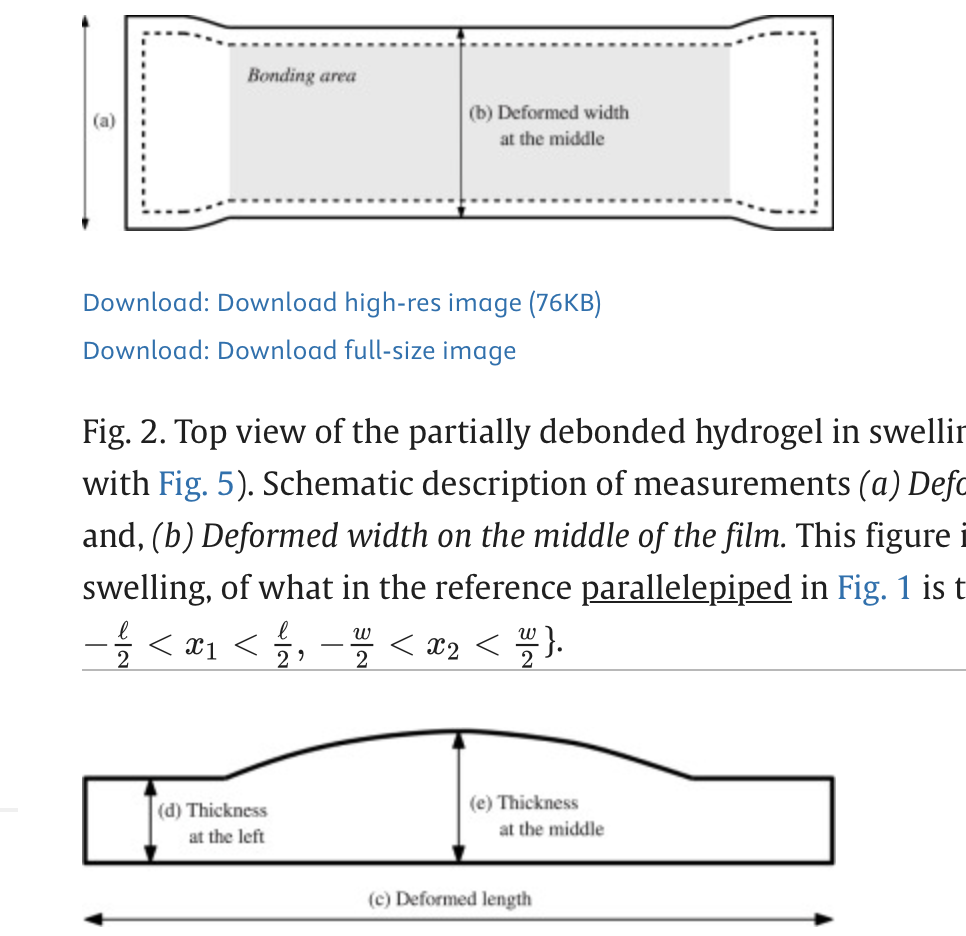

w = 1.62 comparison

In [ ]:
# subplots for all parameters
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
params = ['a', 'b', 'c', 'd', 'e', 'avg_energy']
titles = ['Parameter a', 'Parameter b', 'Parameter c', 'Parameter d', 'Parameter e', 'Average Energy Density [kPa]']
for i, param in enumerate(params):
    ax = axs[i//2, i%2]
    ax.plot(reduced_162['delta'], reduced_162[param], 's-', label='Reduced 2D Model d=1.62')
    ax.plot(df162['delta'], df162[param], 's--', label='Full 3D Model d=1.62')
    ax.set_xlabel('Delta')
    ax.set_ylabel(param)
    ax.set_title(titles[i])
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df162

In [ ]:
slope_reduced , intercept_reduced = np.polyfit(reduced_162['delta'], reduced_162['avg_energy'], 1)
slope_full , intercept_full = np.polyfit(df162['delta'], df162['avg_energy'], 1)

release_rate_reduced = slope_reduced * 1.62
release_rate_full = slope_full * 1.62
print(abs(release_rate_full-release_rate_reduced)/release_rate_full * 100)

In [ ]:
threshold_thickness_full = 1100/slope_full
threshold_thickness_reduced = 1100/slope_reduced
print(f"Threshold thickness full: {threshold_thickness_full}, Reduced: {threshold_thickness_reduced}")
# relative error thickess
relative_error_thickness = abs(threshold_thickness_full - threshold_thickness_reduced) / threshold_thickness_full * 100
print(f"Relative error in threshold thickness: {relative_error_thickness:.2f}%")

energy release rate es cota superior con un error del 27%, al menos entrega cotas superiores.

Traducir a threshold thickness es cota inferior

In [ ]:
reduced_162= reduced_162.reset_index()

reduced_162

## H1 difference 1st attempt
compare all meshes?

In [ ]:
pickle.dump(gfus_and_meshes, open(f"gfus_and_meshes_{name}.pkl", "wb"))

In [ ]:
# read gfu 
w,l,d = gel_measures[1]
print(l,w,d)
delta = 0.9
base_gfu_path_3 = lambda delta: f"/Users/sferra/Desktop/NonLInearElasticity/DimensionReduction3dto2d/finite elements full3D/gridfunctions3_00/result_debonded3D_d=3.00_delta={delta}_order=2.gfu"
gfu_d_3_paths = [base_gfu_path_3(delta) for delta in ["0.100","0.200","0.300","0.400","0.500","0.600","0.700","0.800","0.900"]]
base_path_mesh_3 = lambda n: f"/Users/sferra/Desktop/NonLInearElasticity/DimensionReduction3dto2d/finite elements full3D/meshes3_00/mesh{n}.vol.gz"
meshes_d_3_paths = [base_path_mesh_3(n) for n in range(0,9)]

base_gfu_path_162 = lambda delta: f"/Users/sferra/Desktop/NonLInearElasticity/DimensionReduction3dto2d/finite elements full3D/gridfunctions1_62/result_debonded3D_d=1.62_delta={delta}_order=2.gfu"
gfu_d_162_paths = [base_gfu_path_162(delta) for delta in ["0.100","0.200","0.300","0.400","0.500","0.600","0.700","0.800","0.900"]]
base_path_mesh_162 = lambda n: f"/Users/sferra/Desktop/NonLInearElasticity/DimensionReduction3dto2d/finite elements full3D/meshes1_62/mesh{n}.vol.gz"
meshes_d_162_paths = [base_path_mesh_162(n) for n in range(0,9)]

gfus_loaded_300 = []
gfus_loaded_162 = []
for mesh_path,gfu_path in zip(meshes_d_3_paths,gfu_d_3_paths):
    mesh = Mesh(mesh_path)
    gfu = GridFunction(VectorH1(mesh, order=ord))
    gfu.Load(gfu_path)
    gfus_loaded_300.append(gfu)
for mesh_path,gfu_path in zip(meshes_d_162_paths,gfu_d_162_paths):
    mesh = Mesh(mesh_path)
    gfu = GridFunction(VectorH1(mesh, order=ord))
    gfu.Load(gfu_path)
    gfus_loaded_162.append(gfu)


In [32]:
def H1_distance(gfu1, gfu2):
    diff = gfu1 - gfu2
    grad_diff = Grad(diff)
    return sqrt(Integrate(InnerProduct(diff, diff) + InnerProduct(grad_diff, grad_diff), gfu1.mesh)).Evaluate()

In [ ]:
deltas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# filter results
gfus_and_meshes_to_compare_d300 = [entry for entry in gfus_and_meshes if entry['delta'] in deltas and entry['measures'] == [23.5,90,3.0]]
gfus_and_meshes_to_compare_d162 = [entry for entry in gfus_and_meshes if entry['delta'] in deltas and entry['measures'] == [15.0,90,1.62]]

mapping_test_mesh = lambda x ,y ,z: (x*l/2,y*d,  -w/2 + z*w)
test_mesh = MakeStructured3DMesh(
    nx=200, ny=int(d/h), nz=int(w/h),
    mapping=mapping_test_mesh, hexes= False)
gfu_aux = GridFunction(VectorH1(test_mesh, order=ord))
gfu_test = gfus_loaded_300[0]
gfu_aux.components[0].Set(gfu_test.components[0])
Draw(gfu_test.components[0])
Draw(gfu_aux.components[0])

